# Example of a spin test between two correlated and uncorrelated continous maps on the unfolded hippocampus

In [1]:
import matplotlib.pyplot as plt
import nibabel as nib
import hippomaps as hm
import numpy as np

In [2]:
# Test data
den = '1mm'
thickness = '../example_data/thickness_midsurf_L_mean.shape.gii'
NDI = '../example_data/NDI_midsurf_L_mean.shape.gii'
T1divT2 = '../example_data/T1wdivT2w_midsurf_L.shape.gii'

## Visualize data

Note that these permutation tests rely on sampling to a regular 2D grid (in unfolded space). This is done automatically in each function, but here we also visualize the data as such

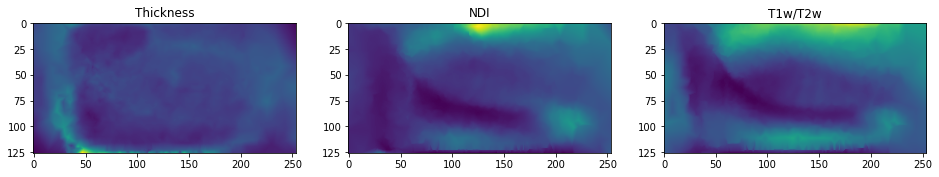

In [3]:
#Load data for visualization only
thickdata = nib.load(thickness).agg_data()
NDIdata = nib.load(NDI).agg_data()
T1divT2data = nib.load(T1divT2).agg_data()

thickdatainterp = hm.utils.density_interp(den,'unfoldiso',thickdata,label='hipp')[0]
thickdatainterp = np.reshape(thickdatainterp,(126,254))#get maps to 124x256
NDIdatainterp = hm.utils.density_interp(den,'unfoldiso',NDIdata,label='hipp')[0]
NDIdatainterp = np.reshape(NDIdatainterp,(126,254))#get maps to 124x256
T1divT2datainterp = hm.utils.density_interp(den,'unfoldiso',T1divT2data,label='hipp')[0]
T1divT2datainterp = np.reshape(T1divT2datainterp,(126,254))#get maps to 124x256

#Visualize example maps
fig, axs = plt.subplots(1,3,figsize=(16,9))
axs[0].imshow(thickdatainterp)
axs[0].set_title('Thickness')
axs[1].imshow(NDIdatainterp)
axs[1].set_title('NDI')
axs[2].imshow(T1divT2datainterp)
axs[2].set_title('T1w/T2w')
plt.show()


### Run spin test (two highly correlated maps)

In [4]:
[metricnull,permutedimg,pval,r_obs] = hm.stats.spin_test(T1divT2,NDI,label='hipp',nperm=5000,den=den,metric='spearman')

p-value between NDI and T1w/T2w = 0.0


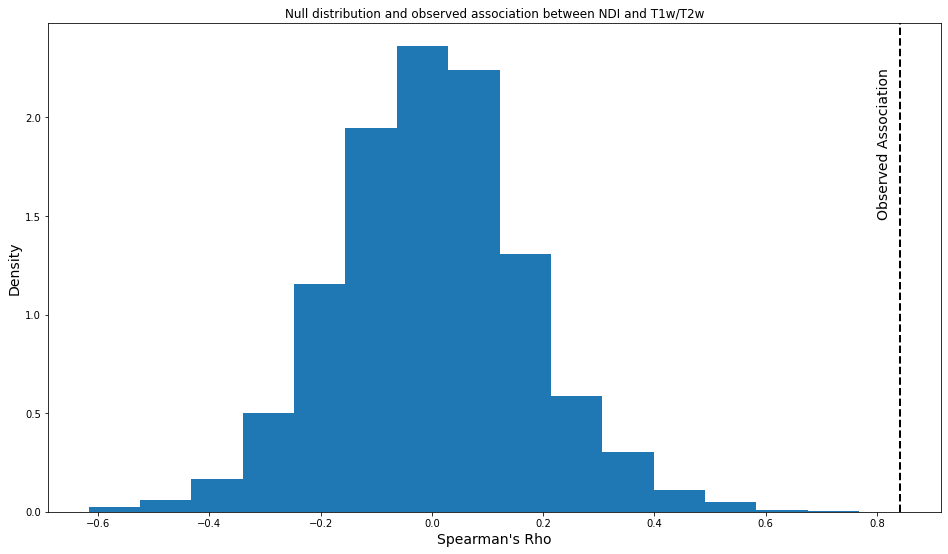

In [5]:
print(f'p-value between NDI and T1w/T2w = {pval:.6}')
fig, ax = plt.subplots(figsize=(16,9))
ax.hist(metricnull,bins=15,density=True)
ax.axvline(r_obs, lw=2, ls='--', color='k')
plt.text(0.8,1.5,'Observed Association',rotation=90,fontsize=14)
plt.xlabel("Spearman's Rho",fontsize=14)
plt.ylabel('Density',fontsize=14)
plt.title('Null distribution and observed association between NDI and T1w/T2w')
plt.show()

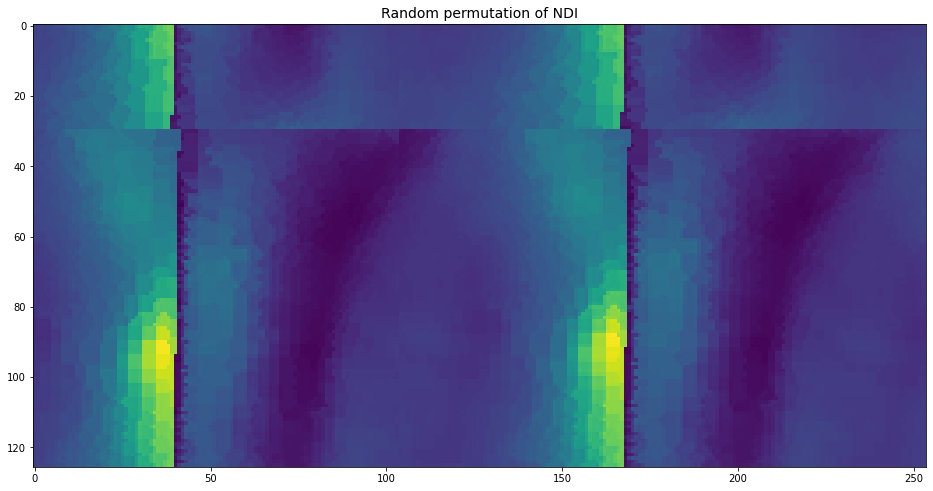

In [6]:
#Visualize a random permuted unfolded map
fig, ax = plt.subplots(figsize=(16,9))
ax.imshow(permutedimg[:,:,2])
plt.title('Random permutation of NDI',fontsize=14)
plt.show()

### Run spin test (two uncorrelated maps)

In [7]:
[metricnull,permutedimg,pval,r_obs] = hm.stats.spin_test(thickness,NDI,label='hipp',nperm=5000,den=den,metric='spearman')

p-value between NDI and Thickness = 0.4524


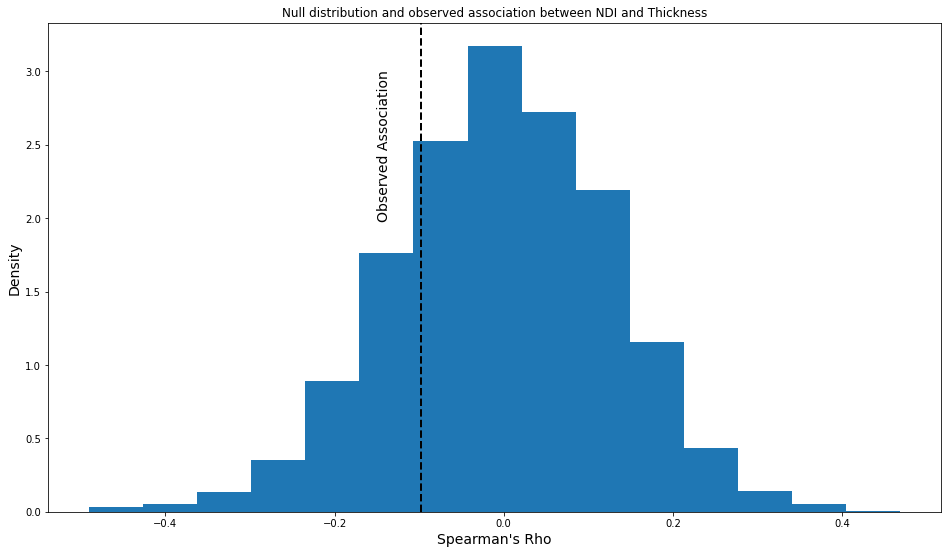

In [8]:
print(f'p-value between NDI and Thickness = {pval:.6}')
fig, ax = plt.subplots(figsize=(16,9))
ax.hist(metricnull,bins=15,density=True)
ax.axvline(r_obs, lw=2, ls='--', color='k')
plt.text(-0.15,2,'Observed Association',rotation=90,fontsize=14)
plt.xlabel("Spearman's Rho",fontsize=14)
plt.ylabel('Density',fontsize=14)
plt.title('Null distribution and observed association between NDI and Thickness')
plt.show()

## Let's try with Moran spactral randomization

In [5]:
[metricnull,permutedimg,pval,r_obs] = hm.stats.moran_test(thickness,NDI,label='hipp',nperm=5000,den=den,metric='spearman')

p-value between NDI and Thickness = 0.0076


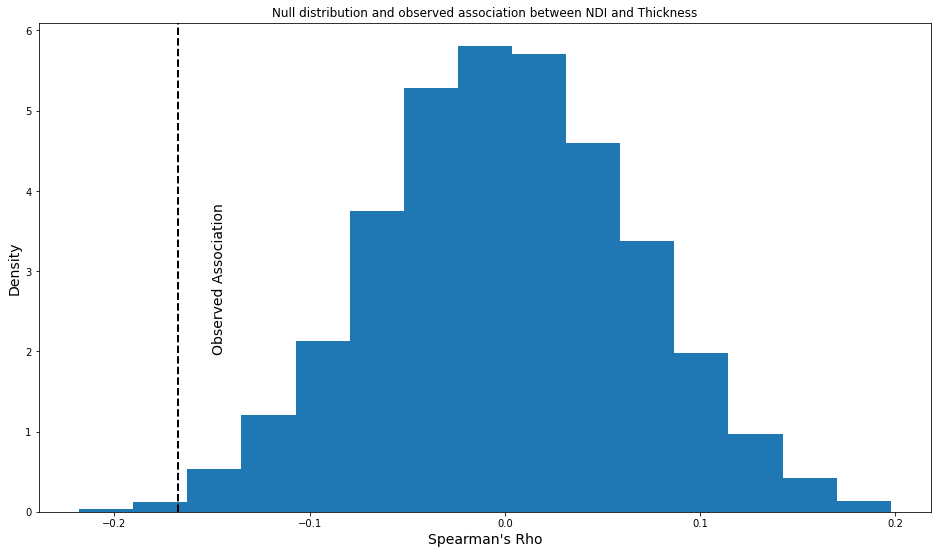

In [6]:
print(f'p-value between NDI and Thickness = {pval:.6}')
fig, ax = plt.subplots(figsize=(16,9))
ax.hist(metricnull,bins=15,density=True)
ax.axvline(r_obs, lw=2, ls='--', color='k')
plt.text(-0.15,2,'Observed Association',rotation=90,fontsize=14)
plt.xlabel("Spearman's Rho",fontsize=14)
plt.ylabel('Density',fontsize=14)
plt.title('Null distribution and observed association between NDI and Thickness')
plt.show()

This method is less conservative, and suffersfrom a higher false-positive rate